In [1]:
import os
import random
import torch
from torch import Generator
from torch.nn import functional as F
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def read_words(file_path):
    with open(file_path, 'r') as file:
        words = set([ word.lower() for word in file.read().splitlines() if word.isalpha() ])
        file.close()
    return list(words)

In [3]:
# read words
words = read_words('../geowords.txt')
print(f'total words: {len(words)}')

total words: 314532


In [4]:
# prepare vocabulary
chars = sorted(list(set(''.join(words))))
stoi = { s:i+1 for i, s in enumerate(chars) }
stoi['.'] = 0
itos = { i:s for s, i in stoi.items() }
vocab_size = len(stoi)
print(f'vocab size: {vocab_size}')
print(f'vocab: {[s for s, _ in stoi.items()]}')

vocab size: 34
vocab: ['ა', 'ბ', 'გ', 'დ', 'ე', 'ვ', 'ზ', 'თ', 'ი', 'კ', 'ლ', 'მ', 'ნ', 'ო', 'პ', 'ჟ', 'რ', 'ს', 'ტ', 'უ', 'ფ', 'ქ', 'ღ', 'ყ', 'შ', 'ჩ', 'ც', 'ძ', 'წ', 'ჭ', 'ხ', 'ჯ', 'ჰ', '.']


In [5]:
random.seed(42069)
random.shuffle(words)

In [6]:
# build dataset of words
block_size = 3
def build_dataset(words_set):
    X, Y = [], []
    for word in words_set:
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
X_train, y_train = build_dataset(words[:n1])
X_dev, y_dev = build_dataset(words[n1:n2])
X_test, y_test = build_dataset(words[n2:])

print(f'---- training set ----')
print(f'input shape: {X_train.shape}')
print(f'label shape: {y_train.shape}')
print(f'total samples: {X_train.shape[0]}')
print(f'---- validation set ----')
print(f'input shape: {X_dev.shape}')
print(f'label shape: {y_dev.shape}')
print(f'total samples: {X_dev.shape[0]}')
print(f'---- testing set ----')
print(f'input shape: {X_test.shape}')
print(f'label shape: {y_test.shape}')
print(f'total samples: {X_test.shape[0]}')

---- training set ----
input shape: torch.Size([2556822, 3])
label shape: torch.Size([2556822])
total samples: 2556822
---- validation set ----
input shape: torch.Size([318584, 3])
label shape: torch.Size([318584])
total samples: 318584
---- testing set ----
input shape: torch.Size([319813, 3])
label shape: torch.Size([319813])
total samples: 319813


In [159]:
class Module:
    def __call__(self, x):
        return self.forward(x)
    def forward(self, x):
        raise NotImplementedError
    def params(self):
        raise NotImplementedError
    
class Linear(Module):
    def __init__(self, fan_in, fan_out, bias=True):
        # batch normalization does not require xavier initialization: fan_in**0.5
        # this initialization works for non-linearities, such as tanh. but won't
        # work for relu or such. if using relu, or other linearities the case
        # of '(fan_in/2)**0.5' will converge and works fine.
        self.weights = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    def forward(self, x):
        self.out = x @ self.weights
        if self.bias is not None: self.out += self.bias
        return self.out
    def params(self):
        return [self.weights] + ([self.bias] if self.bias is not None else [])

class BatchNorm1d(Module):
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # these are the parameters to adjust, tweak
        # and shift normalized data. gamma is a
        # scalar value and beta is a shifter.
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    def forward(self, x):
        # if nn is in training mode we calculate batch
        # mean and variance. else if testing or evaluating
        # we need running mean and variance
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True) #, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # in training mode, we have to update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    def params(self):
        return [self.gamma, self.beta]

class Tanh(Module):
    def forward(self, x):
        self.out = torch.tanh(x)
        return self.out
    def params(self):
        return []

In [201]:
# preparing neural network
n_embd = 10
n_hidden = 100
g = Generator().manual_seed(1200)

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    layers[-1].weights *= 0.1
    # we should apply gain for other 
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weights *= 5/3

params = [C] + [p for layer in layers for p in layer.params()]
print(f"number of parameters: {sum([p.nelement() for p in params])}")
for p in params:
    p.requires_grad = True

number of parameters: 37174


In [202]:
# training phase
max_steps = 200_000
batch_size = 64
lossi = []
ud = []

for i in range(1, max_steps + 1):
    # batch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    X_batch, y_batch = X_train[ix], y_train[ix]

    # forward pass
    emb = C[X_batch]
    # flatten embedded matrix
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y_batch)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for param in params:
        param.grad = None
    loss.backward()

    # update params
    lr = 0.1 if i < 100_000 else 0.01
    for param in params:
        param.data += -lr * param.grad

    # tracking
    if i % 5_000 == 0:
        print(f'step: {i}; loss: {loss.item():.4f}')
    lossi.append(loss.log10().item())    
    with torch.no_grad():
        ud.append([(lr * param.grad.std() / param.data.std()).log10().item() for param in params])
    
    if i >= 1000:
        break

In [165]:
# visualize histrograms
def show_distributions():
    figure, axes = plt.subplots(1, 2, figsize=(15, 4))
    figure.suptitle('Distributions')
    legends = []
    for i, layer in enumerate(layers[:-1]):
        if isinstance(layer, Tanh):
            t = layer.out
            print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
            hy, hx = torch.histogram(t, density=True)
            axes[0].set_title('activation distribution')
            axes[0].plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__})')
            axes[0].legend(legends)
    
    for i, layer in enumerate(layers[:-1]):
        if isinstance(layer, Tanh):
            t = layer.out.grad
            # print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
            hy, hx = torch.histogram(t, density=True)
            axes[1].set_title('grad distribution')
            axes[1].plot(hx[:-1].detach(), hy.detach())
            axes[1].legend(legends)

layer 1 (      Tanh): mean +0.00, std 0.64, saturated: 6.09%
layer 3 (      Tanh): mean +0.00, std 0.52, saturated: 0.41%
layer 5 (      Tanh): mean -0.03, std 0.51, saturated: 0.22%
layer 7 (      Tanh): mean -0.02, std 0.54, saturated: 0.97%


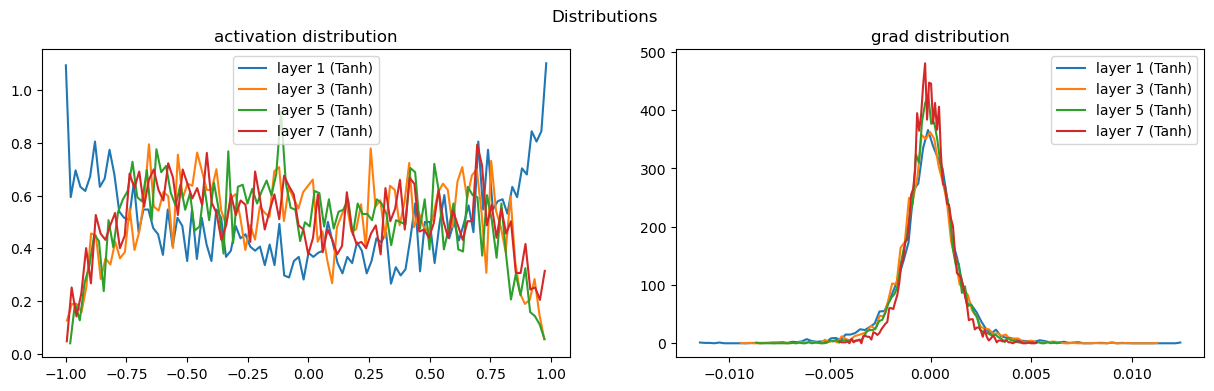

In [166]:
# this is visualization when we weights on each
# layer are scaled by 1 instead of 5/3
# middle layers are going to gradually shrink
# in the middle, which is not the result we want
show_distributions()

layer 1 (      Tanh): mean -0.02, std 0.86, saturated: 45.70%
layer 3 (      Tanh): mean -0.06, std 0.84, saturated: 40.69%
layer 5 (      Tanh): mean -0.03, std 0.86, saturated: 43.59%
layer 7 (      Tanh): mean +0.02, std 0.85, saturated: 43.69%


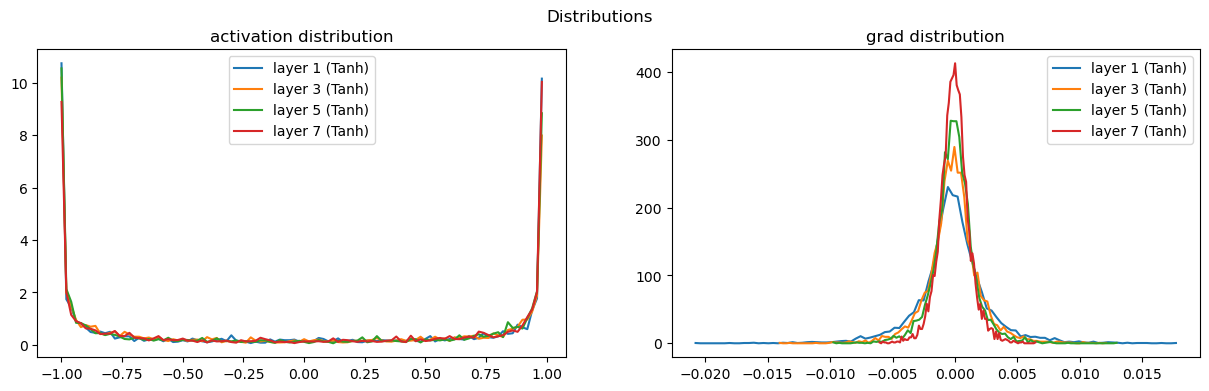

In [169]:
# Weights are scaled by 3
# as you can see outputs are less squiggly
# but they are pushed to the borders
# also grads are shrinking towards the middle
show_distributions()

layer 1 (      Tanh): mean +0.01, std 0.75, saturated: 19.30%
layer 3 (      Tanh): mean +0.01, std 0.71, saturated: 11.25%
layer 5 (      Tanh): mean +0.00, std 0.71, saturated: 10.34%
layer 7 (      Tanh): mean -0.01, std 0.72, saturated: 10.86%


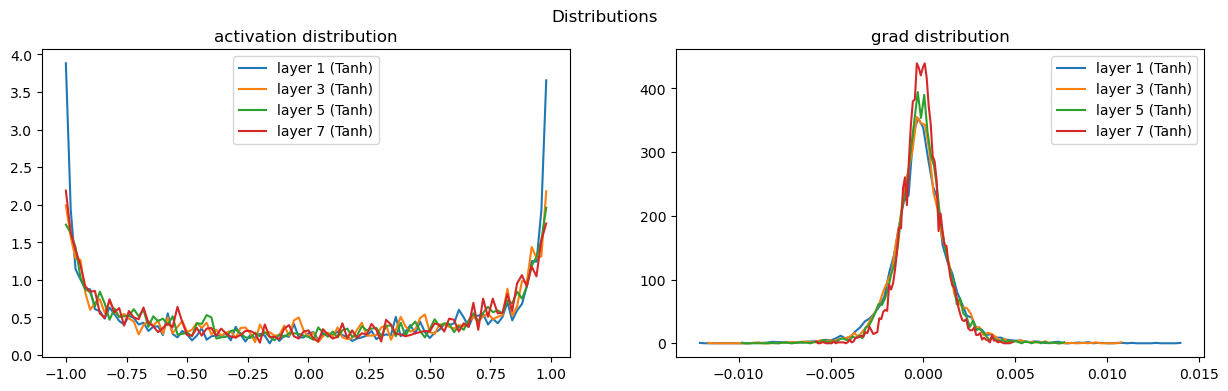

In [203]:
# Weights are scaled by 5/3
# visualize histrograms
show_distributions()

In [175]:
def show_wg_distribution():
    plt.figure(figsize=(15, 4))
    legends = []
    for i, p in enumerate(params):
        t = p.grad
        if p.ndim == 2:
            print('weights %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'{i} {tuple(p.shape)}')
    plt.legend(legends)
    plt.title('weights gradient distribution')

weights   (34, 10) | mean +0.000117 | std 6.783929e-03 | grad:data ratio 7.362700e-03
weights  (30, 100) | mean -0.000238 | std 7.018129e-03 | grad:data ratio 2.379175e-02
weights (100, 100) | mean +0.000060 | std 5.533051e-03 | grad:data ratio 3.312219e-02
weights (100, 100) | mean -0.000029 | std 4.580154e-03 | grad:data ratio 2.726115e-02
weights (100, 100) | mean +0.000007 | std 3.520159e-03 | grad:data ratio 2.093793e-02
weights  (100, 34) | mean +0.000000 | std 1.394177e-02 | grad:data ratio 2.148278e-01


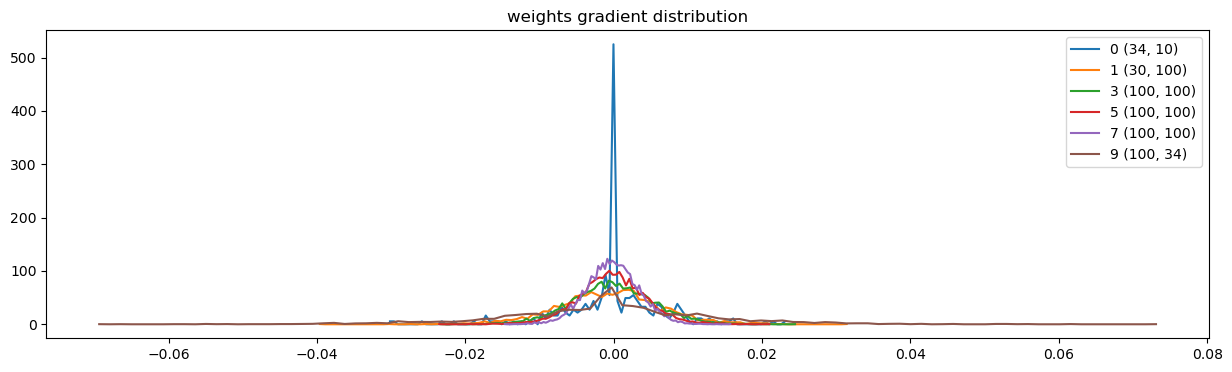

In [176]:
show_wg_distribution()

In [204]:
def show_update_to_data():
    plt.figure(figsize=(15, 4))
    legends = []
    for i, p in enumerate(params):
        if p.ndim == 2:
            plt.plot([ud[j][i] for j in range(len(ud))])
            legends.append('param %d' % i)
    plt.plot([0, len(ud)], [-3, -3], 'k')
    plt.legend(legends)

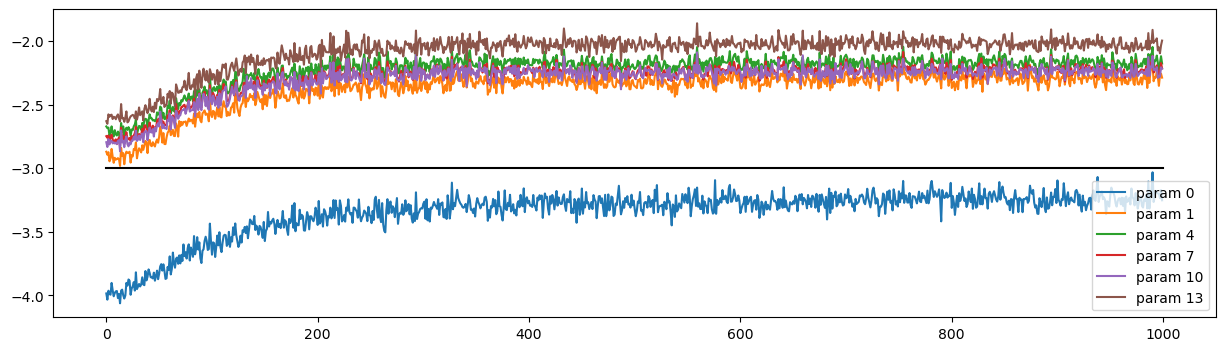

In [199]:
show_update_to_data()

In [205]:
# ----- Added batch normalization layers ------
# preparing neural network
n_embd = 10
n_hidden = 100
g = Generator().manual_seed(1200)

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False),  BatchNorm1d(vocab_size),
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    # layers[-1].weights *= 0.1
    # we should apply gain for other 
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # this scaling factor won't effect anything
            # just gain be 1.0
            layer.weights *= 1.0 # 5/3

params = [C] + [p for layer in layers for p in layer.params()]
print(f"number of parameters: {sum([p.nelement() for p in params])}")
for p in params:
    p.requires_grad = True

number of parameters: 37608


In [206]:
# training phase
max_steps = 200_000
batch_size = 64
lossi = []
ud = []

for i in range(1, max_steps + 1):
    # batch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    X_batch, y_batch = X_train[ix], y_train[ix]

    # forward pass
    emb = C[X_batch]
    # flatten embedded matrix
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y_batch)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for param in params:
        param.grad = None
    loss.backward()

    # update params
    lr = 0.1 if i < 100_000 else 0.01
    for param in params:
        param.data += -lr * param.grad

    # tracking
    if i % 5_000 == 0:
        print(f'step: {i}; loss: {loss.item():.4f}')
    lossi.append(loss.log10().item())    
    with torch.no_grad():
        ud.append([(lr * param.grad.std() / param.data.std()).log10().item() for param in params])
    
    if i >= 1000:
        break

layer    2 (        Tanh): mean -0.00, std 0.63, saturated: 3.72%
layer    5 (        Tanh): mean -0.00, std 0.64, saturated: 3.38%
layer    8 (        Tanh): mean +0.00, std 0.64, saturated: 3.05%
layer   11 (        Tanh): mean +0.00, std 0.65, saturated: 2.52%


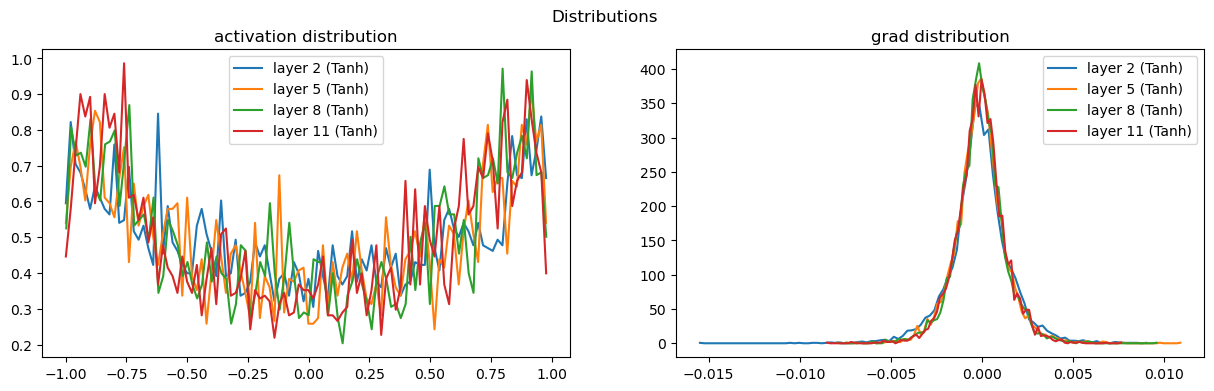

In [207]:
# Weights are scaled by 5/3
# visualize histrograms
figure, axes = plt.subplots(1, 2, figsize=(15, 4))
figure.suptitle('Distributions')
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %4d (%12s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        axes[0].set_title('activation distribution')
        axes[0].plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
        axes[0].legend(legends)

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        # print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        axes[1].set_title('grad distribution')
        axes[1].plot(hx[:-1].detach(), hy.detach())
        axes[1].legend(legends)

weights   (34, 10) | mean +0.000000 | std 4.830534e-03 | grad:data ratio 4.879082e-03
weights  (30, 100) | mean -0.000082 | std 9.941097e-03 | grad:data ratio 5.552295e-02
weights (100, 100) | mean -0.000034 | std 7.194692e-03 | grad:data ratio 7.068644e-02
weights (100, 100) | mean -0.000067 | std 6.448748e-03 | grad:data ratio 6.342749e-02
weights (100, 100) | mean -0.000038 | std 6.464591e-03 | grad:data ratio 6.366555e-02
weights  (100, 34) | mean -0.000099 | std 1.013620e-02 | grad:data ratio 9.704300e-02


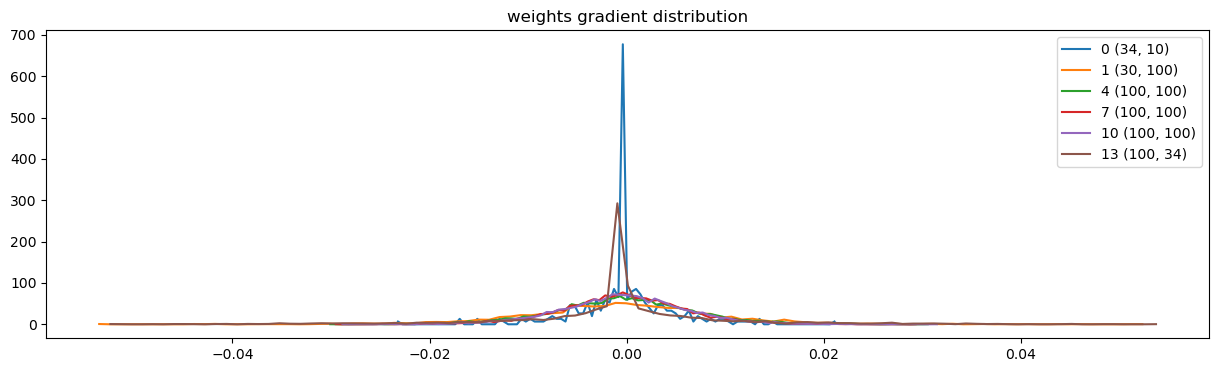

In [208]:
show_wg_distribution()

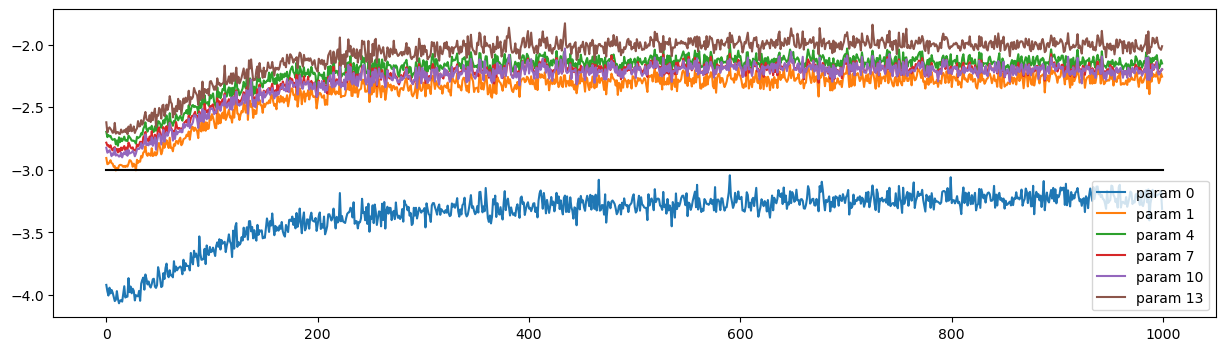

In [209]:
show_update_to_data()